<a href="https://colab.research.google.com/github/artiboi2002/dp-poisoning-attacks/blob/main/dp_poisioning_attacks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
from opacus import PrivacyEngine
import time

transform = transforms.ToTensor() #converting MNIST Image into tensor of 4 dimensions(image, height, wdith, color channel)
#Train Data
trainData = datasets.MNIST(root ='/cnn_data', train = True, download = True, transform = transform)
#Test Data
testData = datasets.MNIST(root = '/cnn_data', train = False, download = True, transform = transform)


In [8]:
class ConvolutionalNeuralNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 6, 3, 1)
    self.conv2 = nn.Conv2d(6, 16, 3,1)
    # Fully connected layer
    self.fc1 = nn.Linear(5*5*16, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x, 2,2) #2x2 kernal and a stride of 2
    x = F.relu(self.conv2(x)) #1 image, 6 output, 3 kernal, 1 stride
    x = F.max_pool2d(x, 2, 2)

    #Review to flatten in out
    x = x.view(-1, 16*5*5)

    #Fully connected layers
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)

    return F.log_softmax(x, dim = 1)

In [9]:
def trainingFunction(model, train_loader,test_loader, epochs, criterion, optimizer):
  train_loss = []
  test_loss = []
  train_correct =[]
  test_correct = []

 #For loop of Epochs
  for i in range(epochs):
    train_corr = 0
    test_corr = 0
    total_samples = 0
    test_total_samples = 0


  #Train
    for b,(X_train, Y_train) in enumerate(train_loader):
      b += 1 #start our batches at 1
      y_pred = model(X_train) #get the predicted values from the training set. Not flaattedned 2D
      loss = criterion(y_pred, Y_train) #How off are we? Compare the prediction to the correct answers in Y_train
      predicted = torch.max(y_pred.data, 1)[1] #we want to add up the correct number of prediciton. Indexed of the first point
      batch_corr = (predicted == Y_train).sum() #we want to know how many we got correct.
      train_corr += batch_corr #keep track as we go aloing in training
      total_samples += Y_train.size(0)

    #Update the parameters
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      if b % 600 == 0:
        print(f'Epoch: {i+1}, Batch {b}, Loss {loss.item(): .4f}')

  #append train loss and train correct into the list
    train_loss.append(loss.item())
    train_correct.append(train_corr.item())

  #Test
    with torch.no_grad():
      for b,(X_test, Y_test) in enumerate(test_loader):
        y_value = model(X_test)
        loss = criterion(y_value, Y_test)
        predicted = torch.max(y_value.data, 1)[1]
        test_corr += (predicted == Y_test).sum()
        test_total_samples += Y_test.size(0)

 #append test loss and train correct into the list
    test_loss.append(loss.item())
    test_correct.append(test_corr.item())
    train_accuracy = 100 * train_corr.item() / total_samples
    test_accuracy = 100 * test_corr.item() / test_total_samples
    print(f"Epoch {i + 1} — Train Accuracy: {train_accuracy:.2f}%")
    print(f"Epoch {i + 1} — Test Accuracy: {test_accuracy:.2f}%")


  return train_loss, test_loss, train_correct, test_correct


In [10]:
torch.manual_seed(41)
model = ConvolutionalNeuralNetwork()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.001) #Smaller the learning rate the longer is gonna take to train
trainLoader = DataLoader(trainData, batch_size=10, shuffle = True)
testLoader = DataLoader(testData, batch_size=10, shuffle = False)
epochs = 15

train_loss, test_loss, train_correct, test_correct = trainingFunction(
    model, trainLoader, testLoader, epochs, criterion, optimizer
)

Epoch: 1, Batch 600, Loss  2.2882
Epoch: 1, Batch 1200, Loss  2.2820
Epoch: 1, Batch 1800, Loss  2.2938
Epoch: 1, Batch 2400, Loss  2.2926
Epoch: 1, Batch 3000, Loss  2.2845
Epoch: 1, Batch 3600, Loss  2.3018
Epoch: 1, Batch 4200, Loss  2.2944
Epoch: 1, Batch 4800, Loss  2.2860
Epoch: 1, Batch 5400, Loss  2.2812
Epoch: 1, Batch 6000, Loss  2.2712
Epoch 1 — Train Accuracy: 19.54%
Epoch 1 — Test Accuracy: 34.44%
Epoch: 2, Batch 600, Loss  2.2348
Epoch: 2, Batch 1200, Loss  2.2412
Epoch: 2, Batch 1800, Loss  2.2510
Epoch: 2, Batch 2400, Loss  2.1709
Epoch: 2, Batch 3000, Loss  2.0136
Epoch: 2, Batch 3600, Loss  1.5550
Epoch: 2, Batch 4200, Loss  1.1141
Epoch: 2, Batch 4800, Loss  0.8262
Epoch: 2, Batch 5400, Loss  0.5869
Epoch: 2, Batch 6000, Loss  0.8845
Epoch 2 — Train Accuracy: 53.95%
Epoch 2 — Test Accuracy: 78.08%
Epoch: 3, Batch 600, Loss  0.6385
Epoch: 3, Batch 1200, Loss  0.5247
Epoch: 3, Batch 1800, Loss  0.4013
Epoch: 3, Batch 2400, Loss  0.2086
Epoch: 3, Batch 3000, Loss  0.782

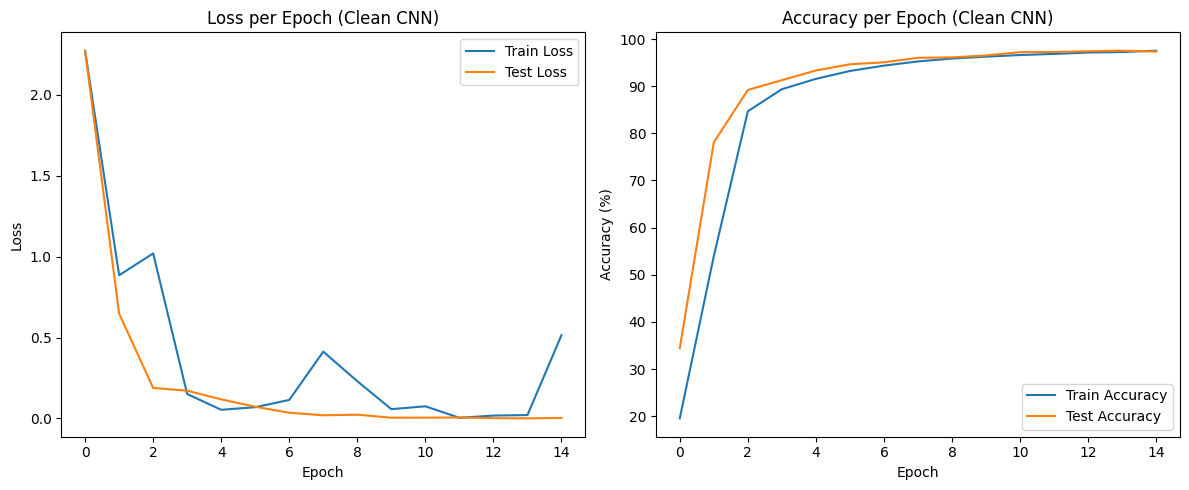

In [11]:
def compute_accuracy(correct_list, total_samples):
    return [100 * (x / total_samples) for x in correct_list]

train_acc = compute_accuracy(train_correct, len(trainLoader.dataset))
test_acc = compute_accuracy(test_correct, len(testLoader.dataset))

plt.figure(figsize=(12, 5))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss')
plt.plot(test_loss, label='Test Loss')
plt.title('Loss per Epoch (Clean CNN)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(test_acc, label='Test Accuracy')
plt.title('Accuracy per Epoch (Clean CNN)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()
